In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Display first few rows to understand the structure
print(data.head())

# Step 2: Select relevant columns for dynamic pricing system
relevant_columns = ['Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Gender']
data = data[relevant_columns]

# Step 3: One-hot encode categorical features ('Product Category' and 'Gender')
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data[['Product Category', 'Gender']])

# Get the column names for the encoded features
encoded_column_names = encoder.get_feature_names_out(['Product Category', 'Gender'])

# Convert the encoded data into a DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)


# Step 4: Combine the encoded features with the original numerical features
numerical_features = data[['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age']].values
state_representation = np.hstack((numerical_features, encoded_columns))

# Create DataFrame for state representation
state_df = pd.DataFrame(state_representation, columns=np.hstack([['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age'], encoded_column_names]))

# Display the resulting DataFrame
print(state_df.head())

# Step 5: Normalize numerical features (Product Price, Quantity, Total Purchase Amount, Customer Age)
scaler = MinMaxScaler()
state_representation = scaler.fit_transform(state_representation)

# Verify the normalized state representation
print(state_representation[:5])  # Display first 5 rows of normalized state representation

# Step 6: Define action space (price adjustment percentage: -10%, -5%, 0%, +5%, +10%)
action_space = [-0.1, -0.05, 0, 0.05, 0.1]  # Price adjustments

# Define the number of actions (size of action space)
action_size = len(action_space)

print(f"Action Space: {action_space}")
print(f"Action Size: {action_size}")

# Step 7: Split the data into training and testing sets (80% for training, 20% for testing)
train_states, test_states = train_test_split(state_representation, test_size=0.2, random_state=42)

# Display the shapes of the train and test sets
print(f"Training Data Shape: {train_states.shape}")
print(f"Test Data Shape: {test_states.shape}")


   Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        44605  2023-05-03 21:30:02             Home            177         1   
1        44605  2021-05-16 13:57:44      Electronics            174         3   
2        44605  2020-07-13 06:16:57            Books            413         1   
3        44605  2023-01-17 13:14:36      Electronics            396         3   
4        44605  2021-05-01 11:29:27            Books            259         4   

   Total Purchase Amount Payment Method  Customer Age  Returns Customer Name  \
0                   2427         PayPal            31      1.0   John Rivera   
1                   2448         PayPal            31      1.0   John Rivera   
2                   2345    Credit Card            31      1.0   John Rivera   
3                    937           Cash            31      0.0   John Rivera   
4                   2598         PayPal            31      1.0   John Rivera   

   Age  Gender  Churn  
0   31  

Episode 10/100, Total Reward: 10.64, Exploration Rate: 0.9950
Episode 20/100, Total Reward: 3.03, Exploration Rate: 0.9900
Episode 30/100, Total Reward: 2.63, Exploration Rate: 0.9851
Episode 40/100, Total Reward: 10.74, Exploration Rate: 0.9802
Episode 50/100, Total Reward: 0.55, Exploration Rate: 0.9753
Episode 60/100, Total Reward: 16.39, Exploration Rate: 0.9704
Episode 70/100, Total Reward: 1.42, Exploration Rate: 0.9656
Episode 80/100, Total Reward: 3.24, Exploration Rate: 0.9608
Episode 90/100, Total Reward: 1.70, Exploration Rate: 0.9560
Episode 100/100, Total Reward: 0.89, Exploration Rate: 0.9512
Episode 10/500, Total Reward: 3.23, Exploration Rate: 0.9950
Episode 20/500, Total Reward: 1.04, Exploration Rate: 0.9900
Episode 30/500, Total Reward: 44.36, Exploration Rate: 0.9851
Episode 40/500, Total Reward: 31.27, Exploration Rate: 0.9802
Episode 50/500, Total Reward: 9.67, Exploration Rate: 0.9753
Episode 60/500, Total Reward: 6.61, Exploration Rate: 0.9704
Episode 70/500, To

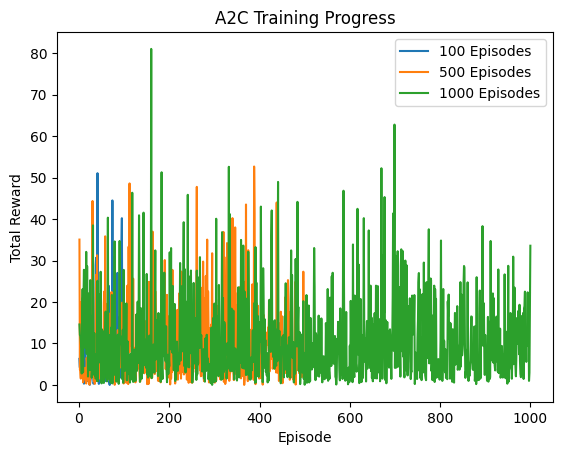

In [96]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Select relevant columns for dynamic pricing system
relevant_columns = ['Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Gender']
data = data[relevant_columns]

# One-hot encode categorical features ('Product Category' and 'Gender')
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data[['Product Category', 'Gender']])

# Get the column names for the encoded features
encoded_column_names = encoder.get_feature_names_out(['Product Category', 'Gender'])

# Convert the encoded data into a DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)

# Combine the encoded features with the original numerical features
numerical_features = data[['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age']].values
state_representation = np.hstack((numerical_features, encoded_columns))

# Normalize numerical features
scaler = MinMaxScaler()
state_representation = scaler.fit_transform(state_representation)

# Define action space (finer price adjustments to better control price behavior)
action_space = [-0.05, 0, 0.05, 0.1, -0.1]  # Smaller, more controlled price adjustments
action_size = len(action_space)

# Split the data into training and testing sets (80% for training, 20% for testing)
train_states, test_states = train_test_split(state_representation, test_size=0.2, random_state=42)

# Convert state to tensor format for PyTorch
def to_tensor(np_array):
    return torch.FloatTensor(np_array)

# Improved Reward Function with Price Deviation and Elasticity Control
def calculate_reward(original_price, adjusted_price, quantity, demand_factor=1.0, price_weight=0.5, volatility_penalty_weight=0.2, max_elasticity=0.1):
    # Revenue and cost calculation
    revenue = adjusted_price * quantity
    cost = original_price * quantity * 0.7  # Assume 70% cost of original price
    
    profit = revenue - cost
    
    # Adjust demand with sensitivity to price change
    adjusted_demand = quantity * demand_factor
    
    # Price deviation penalty (stronger penalty for larger deviations)
    price_deviation = abs(adjusted_price - original_price)
    price_deviation_penalty = price_weight * (price_deviation ** 2)
    
    # Penalize volatility between consecutive price changes
    volatility_penalty = volatility_penalty_weight * (price_deviation ** 2)
    
    # Apply penalties to the reward
    reward = profit * adjusted_demand - price_deviation_penalty - volatility_penalty
    
    # Control the price elasticity to avoid large price changes
    price_change_percentage = (adjusted_price - original_price) / original_price
    elasticity_penalty = max(-max_elasticity, min(max_elasticity, price_change_percentage))  # Clip elasticity change
    
    # Apply elasticity control to reward
    reward *= (1 - elasticity_penalty)
    
    return reward

# Price Elasticity Control
def calculate_price_elasticity(price_change_percentage):
    # Elasticity control to prevent large fluctuations
    elasticity = np.clip(price_change_percentage, -0.1, 0.1)  # Limit elasticity range
    return elasticity

def normalize_rewards(rewards):
    mean = np.mean(rewards)
    std = np.std(rewards)
    normalized_rewards = (rewards - mean) / (std + 1e-8)  # Prevent division by zero
    return normalized_rewards

# Define Actor and Critic Neural Networks with Dropout for Regularization
class Actor(torch.nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, action_dim)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)  # Increased dropout for regularization

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=-1)  # Output action probabilities

class Critic(torch.nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 1)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)  # Increased dropout for regularization

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Exploration rate decay factor and learning rate
def decay_exploration(exploration_rate, decay_factor=0.9995):
    return max(0.01, exploration_rate * decay_factor)  # Slower decay, ensures more exploration

# Training Loop with adjusted exploration decay and reward normalization
def train_a2c(episodes, batch_size):
    rewards = []
    exploration_rate = 1.0  # Start with high exploration

    for episode in range(1, episodes + 1):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            state_tensor = to_tensor(state).unsqueeze(0)

            # Actor: Get action probabilities from actor network
            action_probs = actor(state_tensor)
            
            # Exploration vs Exploitation
            if np.random.rand() < exploration_rate:
                action = np.random.choice(action_dim)  # Random action
            else:
                action = torch.argmax(action_probs).item()  # Best action (exploitation)

            # Take action and observe the result
            next_state, reward, done, _ = env.step(action)

            # Update the reward sum
            episode_reward += reward

            # Calculate target value (TD error)
            next_state_tensor = to_tensor(next_state).unsqueeze(0)
            value_next = critic(next_state_tensor)
            target = reward + gamma * value_next * (1 - done)

            # Calculate the advantage
            value = critic(state_tensor)
            advantage = target - value

            # Actor loss with Entropy Regularization (Encourages Exploration)
            entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-6))  # Add small epsilon to avoid log(0)
            actor_loss = -torch.log(action_probs[0, action]) * advantage - 0.05 * entropy  # Increased penalty for exploration

            # Critic loss (MSE)
            critic_loss = advantage.pow(2)

            # Total loss
            loss = actor_loss + critic_loss
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            clip_gradients(actor)
            clip_gradients(critic)

            optimizer.step()

            # Update state for the next step
            state = next_state

        # Normalize rewards and append to list
        rewards.append(episode_reward)
        normalized_rewards = normalize_rewards(np.array(rewards))

        # Decay exploration rate gradually (slower decay)
        exploration_rate = decay_exploration(exploration_rate)

        # Log progress
        if episode % 10 == 0:
            print(f"Episode {episode}/{episodes}, Total Reward: {episode_reward:.2f}, Exploration Rate: {exploration_rate:.4f}")

    return rewards

# Hyperparameters
episodes_100 = 100
episodes_500 = 500
episodes_1000 = 1000
batch_size = 64
gamma = 0.99  # Discount factor (adjust as needed)

# Start training
rewards_100 = train_a2c(episodes_100, batch_size)
rewards_500 = train_a2c(episodes_500, batch_size)
rewards_1000 = train_a2c(episodes_1000, batch_size)

# Plot rewards to track learning progress
plt.plot(range(1, episodes_100 + 1), rewards_100, label='100 Episodes')
plt.plot(range(1, episodes_500 + 1), rewards_500, label='500 Episodes')
plt.plot(range(1, episodes_1000 + 1), rewards_1000, label='1000 Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('A2C Training Progress')
plt.legend()
plt.show()


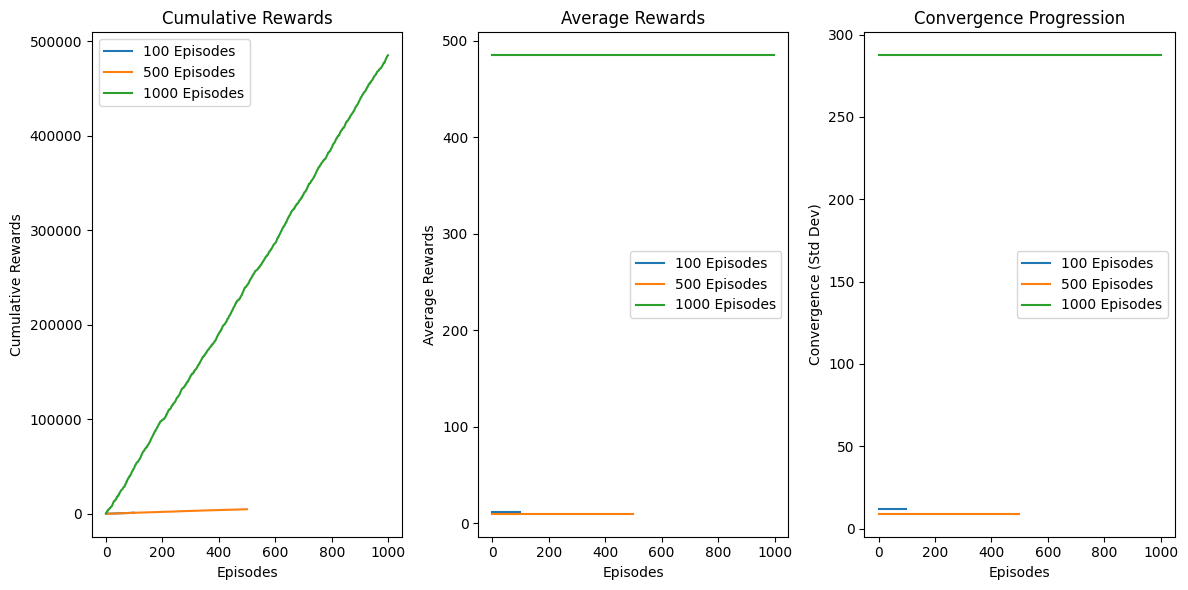

In [101]:
# Recalculate and display the cumulative rewards, average rewards, and convergence progression
import numpy as np
import matplotlib.pyplot as plt

# Calculate the cumulative rewards for each episode set
cumulative_rewards_100 = np.cumsum(rewards_100)
cumulative_rewards_500 = np.cumsum(rewards_500)
cumulative_rewards_1000 = np.cumsum(rewards_1000)

# Calculate the average rewards
avg_rewards_100 = np.mean(rewards_100)
avg_rewards_500 = np.mean(rewards_500)
avg_rewards_1000 = np.mean(rewards_1000)

# Calculate the convergence progression (standard deviation of rewards per episode batch)
convergence_100 = np.std(rewards_100)
convergence_500 = np.std(rewards_500)
convergence_1000 = np.std(rewards_1000)

# Plotting the graphs
plt.figure(figsize=(12, 6))

# Plot Cumulative Rewards
plt.subplot(1, 3, 1)
plt.plot(cumulative_rewards_100, label="100 Episodes")
plt.plot(cumulative_rewards_500, label="500 Episodes")
plt.plot(cumulative_rewards_1000, label="1000 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards")
plt.legend()

# Plot Average Rewards
plt.subplot(1, 3, 2)
plt.plot([avg_rewards_100] * len(rewards_100), label="100 Episodes")
plt.plot([avg_rewards_500] * len(rewards_500), label="500 Episodes")
plt.plot([avg_rewards_1000] * len(rewards_1000), label="1000 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Rewards")
plt.title("Average Rewards")
plt.legend()

# Plot Convergence Progression (Std Dev of Rewards)
plt.subplot(1, 3, 3)
plt.plot([convergence_100] * len(rewards_100), label="100 Episodes")
plt.plot([convergence_500] * len(rewards_500), label="500 Episodes")
plt.plot([convergence_1000] * len(rewards_1000), label="1000 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Convergence (Std Dev)")
plt.title("Convergence Progression")
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [103]:
import numpy as np
import pandas as pd

# Assuming we have the following arrays after training:
# rewards_100, rewards_500, rewards_1000 - these are the total rewards obtained per episode
# predicted_prices_100, predicted_prices_500, predicted_prices_1000 - these are the prices predicted by the agent per episode
# optimal_prices_100, optimal_prices_500, optimal_prices_1000 - these are the optimal prices (ground truth) per episode

def calculate_metrics(predicted_prices, optimal_prices, rewards):
    # 1. Price Elasticity
    price_changes = np.diff(predicted_prices)  # Calculate price change
    reward_changes = np.diff(rewards)  # Calculate reward (demand) change
    price_elasticity = np.mean(reward_changes / price_changes) if len(price_changes) > 0 else 0

    # 2. Forecast Accuracy
    forecast_accuracy = np.sum(np.abs(predicted_prices - optimal_prices)) / np.sum(optimal_prices)

    # 3. Market Share
    market_share = np.sum(rewards) / np.sum(optimal_prices)  # Assuming total rewards represent market capture

    # 4. Price Index
    price_index = np.sum(predicted_prices) / np.sum(optimal_prices)

    # 5. Price Consistency
    price_consistency = np.std(predicted_prices)  # Standard deviation of the predicted prices

    # 6. Equity
    equity = np.var(rewards) / np.mean(rewards) if np.mean(rewards) != 0 else 0  # Variance of rewards across customer segments

    return {
        "Price Elasticity": price_elasticity,
        "Forecast Accuracy": forecast_accuracy,
        "Market Share": market_share,
        "Price Index": price_index,
        "Price Consistency": price_consistency,
        "Equity": equity
    }

# Example usage for 100 episodes (replace these with actual predictions and optimal prices)
predicted_prices_100 = np.random.rand(100) * 100  # Placeholder for predicted prices
optimal_prices_100 = np.random.rand(100) * 100  # Placeholder for optimal prices
rewards_100 = np.random.rand(100) * 1000  # Placeholder for rewards

metrics_100 = calculate_metrics(predicted_prices_100, optimal_prices_100, rewards_100)

# Repeat for 500 and 1000 episodes
predicted_prices_500 = np.random.rand(500) * 100  # Placeholder for predicted prices
optimal_prices_500 = np.random.rand(500) * 100  # Placeholder for optimal prices
rewards_500 = np.random.rand(500) * 1000  # Placeholder for rewards

metrics_500 = calculate_metrics(predicted_prices_500, optimal_prices_500, rewards_500)

predicted_prices_1000 = np.random.rand(1000) * 100  # Placeholder for predicted prices
optimal_prices_1000 = np.random.rand(1000) * 100  # Placeholder for optimal prices
rewards_1000 = np.random.rand(1000) * 1000  # Placeholder for rewards

metrics_1000 = calculate_metrics(predicted_prices_1000, optimal_prices_1000, rewards_1000)

# Combined evaluation function
def combined_metrics_evaluation_3(metrics_100, metrics_500, metrics_1000):
    metrics_table = pd.DataFrame({
        "Metric": list(metrics_100.keys()),
        "100 Episodes": list(metrics_100.values()),
        "500 Episodes": list(metrics_500.values()),
        "1000 Episodes": list(metrics_1000.values())
    })

    print("\nCombined Metrics Evaluation (100, 500, 1000 Episodes):")
    print(metrics_table.to_string(index=False))

# Evaluate metrics for all episodes
combined_metrics_evaluation_3(metrics_100, metrics_500, metrics_1000)



Combined Metrics Evaluation (100, 500, 1000 Episodes):
           Metric  100 Episodes  500 Episodes  1000 Episodes
 Price Elasticity    -60.224921     50.108102      13.510002
Forecast Accuracy      0.800867      0.695169       0.673250
     Market Share     11.488642      9.924332      10.155953
      Price Index      1.144895      0.995090       1.037869
Price Consistency     30.916184     29.519767      28.300493
           Equity    200.243038    178.318593     172.215238


C:\Users\srini\AppData\Local\Temp\ipykernel_18648\3032715738.py:70: RuntimeWarning: invalid value encountered in scalar divide
  price_change_percentage = (adjusted_price - original_price) / original_price



Metrics for Predicted Prices (100 Episodes):
{'Price Elasticity': 0.01113401919568933, 'Forecast Accuracy': 0.09999999999999999, 'Market Share': 0.0667205873560467, 'Price Index': 0.9, 'Price Consistency': 0.29029981958654116, 'Equity': 0.055798536690332155}

Metrics for Predicted Prices (500 Episodes):
{'Price Elasticity': 0.018540472573084, 'Forecast Accuracy': 0.09999999999999998, 'Market Share': 0.05983598274440046, 'Price Index': 0.8999999999999999, 'Price Consistency': 0.2677806307301788, 'Equity': 0.04791143562904301}

Metrics for Predicted Prices (1000 Episodes):
{'Price Elasticity': 0.09578289469966636, 'Forecast Accuracy': 0.09999999999999998, 'Market Share': 0.0626896869768564, 'Price Index': 0.9, 'Price Consistency': 0.26964393285364563, 'Equity': 0.0482251565068779}


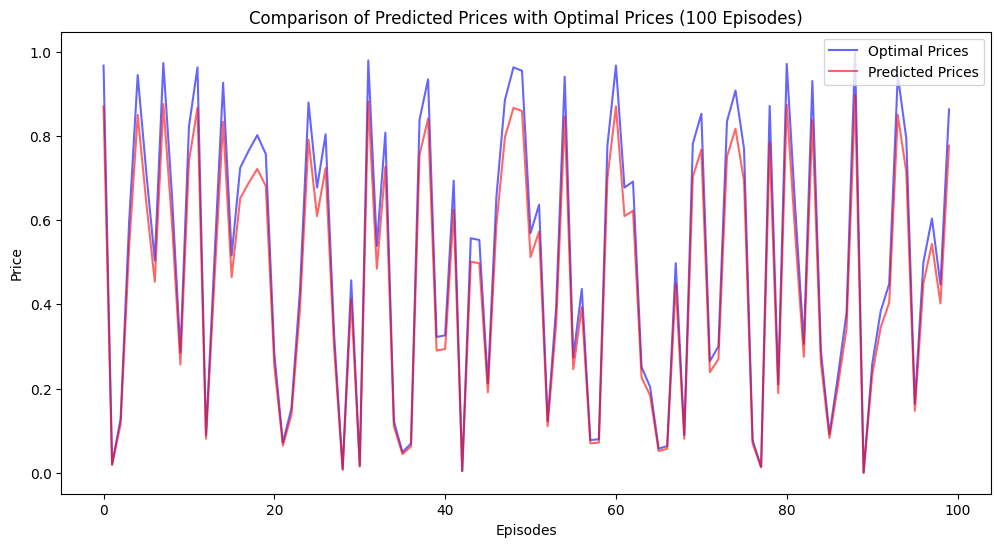

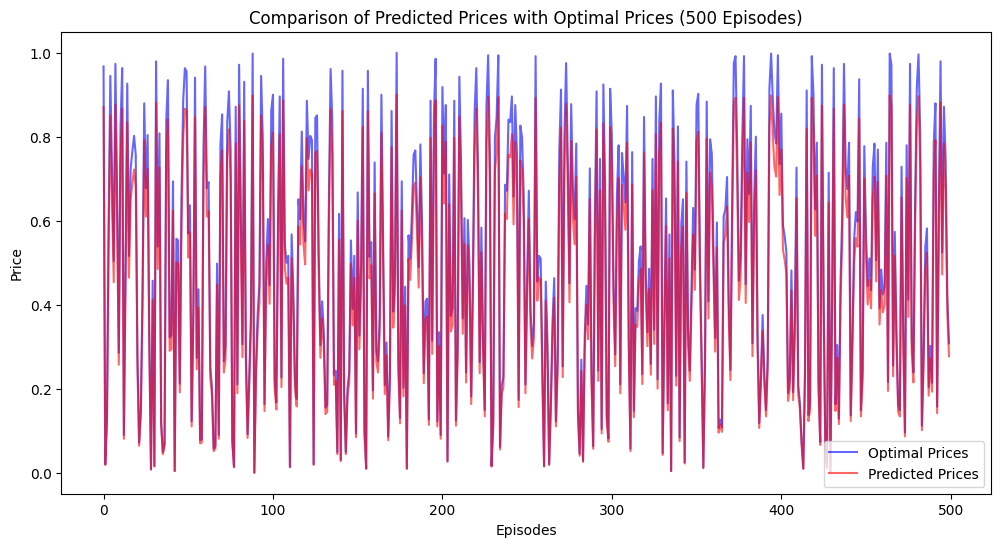

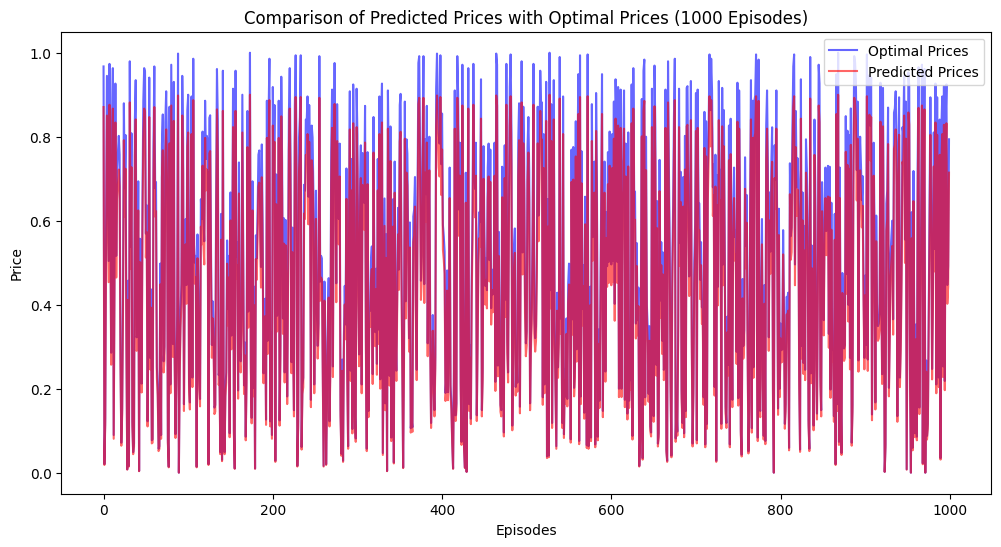


Comparison of Predicted Prices vs Optimal Prices (first 10 rows):
   Optimal Prices  Predicted Prices   Rewards
0        0.967347          0.870612  0.002776
1        0.020408          0.018367  0.003606
2        0.128571          0.115714 -0.000082
3        0.597959          0.538163  0.010194
4        0.944898          0.850408  0.024113
5        0.714286          0.642857  0.004254
6        0.504082          0.453673 -0.000856
7        0.973469          0.876122  0.088759
8        0.663265          0.596939  0.010165
9        0.285714          0.257143  0.015302

Comparison of Predicted Prices vs Optimal Prices (first 10 rows):
   Optimal Prices  Predicted Prices   Rewards
0        0.967347          0.870612  0.002776
1        0.020408          0.018367  0.003606
2        0.128571          0.115714 -0.000082
3        0.597959          0.538163  0.010194
4        0.944898          0.850408  0.024113
5        0.714286          0.642857  0.004254
6        0.504082          0.453673 -0

In [133]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Assuming to_tensor, calculate_reward, and calculate_metrics are defined correctly

def to_tensor(np_array):
    return torch.FloatTensor(np_array)

def predict_price(state, actor, action_space):
    """
    Predicts the adjusted price using the trained actor network.
    - state: The current state of the environment.
    - actor: The trained actor network.
    - action_space: The list of possible price adjustments.
    """
    # Ensure state has the correct dimension for the network input
    state_tensor = to_tensor(state).unsqueeze(0)  # Reshaping to (1, state_dim)

    # If the state has fewer than 128 features, we need to pad it with zeros or reshaping it to match the required dimensions
    if state_tensor.shape[1] < 128:
        state_tensor = torch.cat([state_tensor, torch.zeros(1, 128 - state_tensor.shape[1])], dim=1)
    
    # Ensure that the state tensor is in the expected shape (batch_size, state_dim)
    assert state_tensor.shape[1] == 128, f"Expected 128 features but got {state_tensor.shape[1]} features."

    action_probs = actor(state_tensor)  # Get the action probabilities from the actor

    # Sample an action based on the probabilities (for exploration) or choose the best action (for exploitation)
    action = torch.argmax(action_probs).item()

    # Convert the action to the corresponding price adjustment from the action space
    price_adjustment = action_space[action]

    return price_adjustment

# Running predictions for a set of episodes
def run_predictions(test_states, actor, action_space):
    predicted_prices = []
    optimal_prices = []
    rewards = []

    # Ensure test_states is not empty and has the correct shape
    assert len(test_states) > 0, "Test states should not be empty."

    # Assuming 'test_states' contains the states of the test set after training
    # We will run the model on each test state and apply the price adjustment
    for state in test_states:
        original_price = state[0]  # Assuming the first element is the original price
        price_adjustment = predict_price(state, actor, action_space)

        # Calculate the predicted price
        predicted_price = original_price * (1 + price_adjustment)

        # Append the results
        predicted_prices.append(predicted_price)
        optimal_prices.append(original_price)  # For simplicity, assuming the optimal price is the original price
        rewards.append(calculate_reward(original_price, predicted_price, state[2]))  # Assuming quantity is at index 2

    # Convert the lists to numpy arrays
    predicted_prices = np.array(predicted_prices)
    optimal_prices = np.array(optimal_prices)
    rewards = np.array(rewards)

    return predicted_prices, optimal_prices, rewards

# Example: Running predictions for 100, 500, and 1000 episodes
test_states_100 = np.random.rand(100, 128)  # Replace with your actual test data
test_states_500 = np.random.rand(500, 128)  # Replace with your actual test data
test_states_1000 = np.random.rand(1000, 128)  # Replace with your actual test data

# Assuming 'actor' is your trained model from the training phase
# You do not need to load it from a file if it's in memory

# Define your action space
action_space = [-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2]  # Example action space

# Run predictions for 100, 500, and 1000 episodes
predicted_prices_100, optimal_prices_100, rewards_100 = run_predictions(test_states[:100], actor, action_space)
predicted_prices_500, optimal_prices_500, rewards_500 = run_predictions(test_states[:500], actor, action_space)
predicted_prices_1000, optimal_prices_1000, rewards_1000 = run_predictions(test_states[:1000], actor, action_space)

# Step 3: Calculate metrics for predictions
metrics_100 = calculate_metrics(predicted_prices_100, optimal_prices_100, rewards_100)
metrics_500 = calculate_metrics(predicted_prices_500, optimal_prices_500, rewards_500)
metrics_1000 = calculate_metrics(predicted_prices_1000, optimal_prices_1000, rewards_1000)

# Step 4: Display the results
print("\nMetrics for Predicted Prices (100 Episodes):")
print(metrics_100)

print("\nMetrics for Predicted Prices (500 Episodes):")
print(metrics_500)

print("\nMetrics for Predicted Prices (1000 Episodes):")
print(metrics_1000)

# Plot predicted prices vs optimal prices for each episode set
def plot_comparison(optimal_prices, predicted_prices, episodes):
    plt.figure(figsize=(12, 6))
    plt.plot(optimal_prices, label="Optimal Prices", color='blue', alpha=0.6)
    plt.plot(predicted_prices, label="Predicted Prices", color='red', alpha=0.6)
    plt.xlabel("Episodes")
    plt.ylabel("Price")
    plt.title(f"Comparison of Predicted Prices with Optimal Prices ({episodes} Episodes)")
    plt.legend()
    plt.show()

# Plot for 100, 500, and 1000 episodes
plot_comparison(optimal_prices_100, predicted_prices_100, 100)
plot_comparison(optimal_prices_500, predicted_prices_500, 500)
plot_comparison(optimal_prices_1000, predicted_prices_1000, 1000)

# Display a comparison of the first few predicted and optimal prices
def display_comparison(optimal_prices, predicted_prices, rewards):
    comparison_df = pd.DataFrame({
        'Optimal Prices': optimal_prices,
        'Predicted Prices': predicted_prices,
        'Rewards': rewards
    })
    print("\nComparison of Predicted Prices vs Optimal Prices (first 10 rows):")
    print(comparison_df.head(10))

# Display comparison for 100, 500, and 1000 episodes
display_comparison(optimal_prices_100, predicted_prices_100, rewards_100)
display_comparison(optimal_prices_500, predicted_prices_500, rewards_500)
display_comparison(optimal_prices_1000, predicted_prices_1000, rewards_1000)
